In [284]:
%load_ext lab_black
import pandas as pd
import os
import numpy as np
import datetime as dt
from tqdm import tqdm
import logging
from xgboost import XGBRegressor
from sklearn.externals import joblib
from matplotlib import pyplot as plt
from pandarallel import pandarallel

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [285]:
ic_curve_info_charging_df = pd.read_parquet("ic_curve_info_charging_df.parquet")

In [286]:
ic_curve_info_charging_df.drop_duplicates("machine")

,machine,time,SOC,proc,总电流(A),ic_instant,ic_diff,v_0,v_1,v_2,...,v_332_ic_delta,v_333_ic_delta,v_334_ic_delta,v_335_ic_delta,v_336_ic_delta,v_337_ic_delta,v_338_ic_delta,v_339_ic_delta,v_340_ic_delta,v_341_ic_delta
index,,,,,,,,,,,,,,,,,,,,,
0,LA83F1HT0LA501126,2021-05-01 22:11:52,54,1,-58.200001,0.273882,0.007608,3.282,3.284,3.284,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
0,LA83F1HT2LA501127,2021-05-01 21:17:19,58,30,-139.100006,0.654588,0.018183,3.315,3.317,3.315,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
486,LA83F1HT5HA301270,2021-06-28 10:21:10,76,59,-69.900002,0.328941,0.009137,3.285,3.289,3.284,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
0,LA83F1HT7LA501124,2021-05-01 21:55:04,56,67,-137.600006,0.647529,0.017987,3.308,3.309,3.309,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
0,LA83F1HT7LA501138,2021-05-01 22:06:26,59,98,-113.500000,0.534118,0.014837,3.301,3.303,3.302,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
0,LA83F1HT8JA101134,2021-06-28 10:31:50,63,132,-11.100000,0.052235,0.001451,3.745,3.748,3.747,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
0,LA83F1HT8LA501147,2021-05-01 22:22:49,50,146,-40.400002,0.190118,0.005281,3.282,3.282,3.283,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
0,LA83J1JT0LA101768,2021-05-01 12:20:36,72,176,-119.800003,0.563765,0.015660,3.343,3.346,3.343,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
0,LA83J1JT2LA101769,2021-05-01 00:50:52,44,197,-81.699997,0.384471,0.010680,3.309,3.310,3.309,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


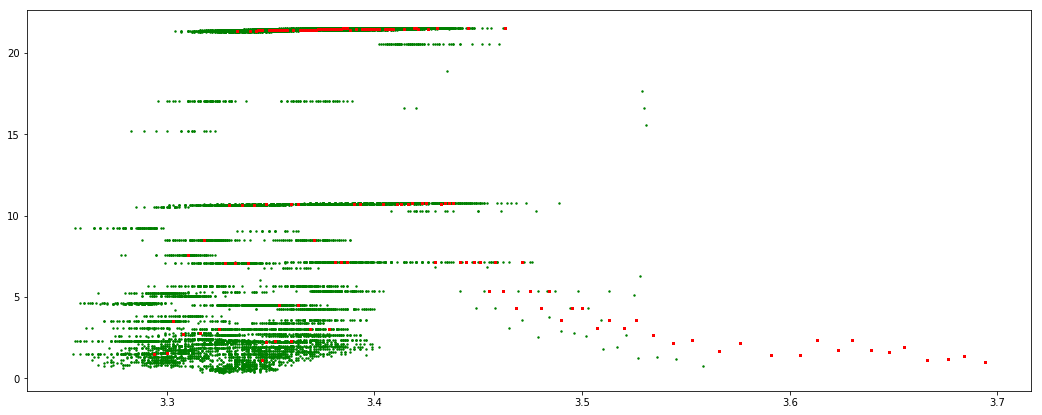

In [288]:
plt.figure(figsize=(18, 7))
test = ic_curve_info_charging_df.loc[
    (ic_curve_info_charging_df.loc[:, "proc"] == 65),
    :,
]
for i in range(0, 342):
    plt.scatter(
        test.loc[:, "v_" + str(i)], test.loc[:, "v_" + str(i) + "_ic_delta"], s=2, c="g"
    )
    plt.scatter(test.loc[:, "v_47"], test.loc[:, "v_47_ic_delta"], s=2, c="red")
    plt.show()

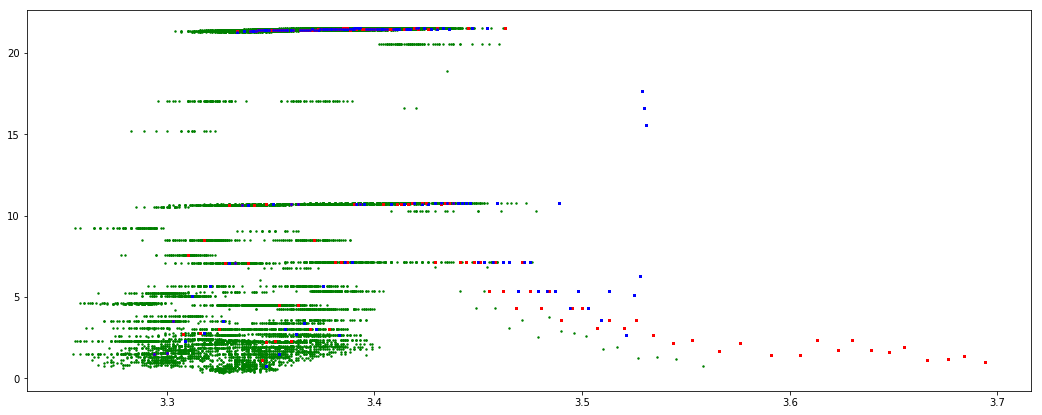

In [289]:
plt.figure(figsize=(18, 7))
test = ic_curve_info_charging_df.loc[
    (ic_curve_info_charging_df.loc[:, "proc"] == 65),
    :,
]
for i in range(0, 342):
    plt.scatter(
        test.loc[:, "v_" + str(i)], test.loc[:, "v_" + str(i) + "_ic_delta"], s=2, c="g"
    )
    plt.scatter(test.loc[:, "v_47"], test.loc[:, "v_47_ic_delta"], s=2, c="red")

In [290]:
X_fit = []
for k in range(test.shape[0]):
    for i in range(342):
        if (test.loc[k, "v_" + str(i)] > 2) & (
            test.loc[k, "v_" + str(i) + "_ic_delta"] < 1000
        ):
            X_fit.append(
                test.loc[k, ["v_" + str(i), "v_" + str(i) + "_ic_delta"]].values.astype(
                    "float"
                )
            )

# X_fit

In [39]:
ic_curve_info_charging_df.loc[ic_curve_info_charging_df.loc[:, "proc"] == 62, :]

,machine,time,SOC,proc,总电流(A),ic_instant,ic_diff,v_0,v_1,v_2,...,v_332_ic_delta,v_333_ic_delta,v_334_ic_delta,v_335_ic_delta,v_336_ic_delta,v_337_ic_delta,v_338_ic_delta,v_339_ic_delta,v_340_ic_delta,v_341_ic_delta
index,,,,,,,,,,,,,,,,,,,,,
0,LA83F1HT5HA301270,2021-06-30 11:26:20,70,63,-35.200001,0.165647,0.004601,3.284,3.289,3.271,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,LA83F1HT5HA301270,2021-06-30 11:26:30,70,63,-35.200001,0.165647,0.004601,3.286,3.291,3.274,...,2.300654,2.300654,2.300654,1.533769,inf,inf,inf,inf,inf,inf
2,LA83F1HT5HA301270,2021-06-30 11:26:40,70,63,-70.000000,0.329412,0.009150,3.294,3.297,3.285,...,0.915033,1.307190,1.307190,1.307190,inf,inf,inf,inf,inf,inf
3,LA83F1HT5HA301270,2021-06-30 11:26:50,70,63,-69.900002,0.328941,0.009137,3.297,3.300,3.290,...,1.827451,2.284314,2.284314,2.284314,inf,inf,inf,inf,inf,inf
4,LA83F1HT5HA301270,2021-06-30 11:27:00,70,63,-104.500000,0.491765,0.013660,3.306,3.306,3.301,...,1.366013,1.951447,1.707516,1.951447,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,LA83F1HT5HA301270,2021-06-30 12:51:50,97,63,-109.500000,0.515294,0.014314,3.393,3.411,3.416,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
335,LA83F1HT5HA301270,2021-06-30 12:52:00,98,63,-100.500000,0.472941,0.013137,3.390,3.408,3.412,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
336,LA83F1HT5HA301270,2021-06-30 12:52:10,98,63,-94.099998,0.442824,0.012301,3.387,3.405,3.407,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


i=304


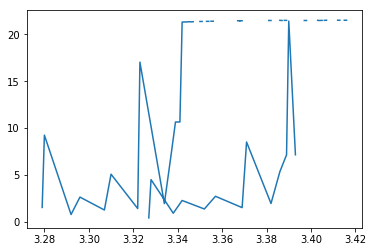

In [147]:
import random

i = random.randint(0, 342)
print("i=" + str(i))
plt.plot(test.loc[:, "v_" + str(i)], test.loc[:, "v_" + str(i) + "_ic_delta"])
# plt.plot(test.loc[:, "v_47"], test.loc[:, "v_47_ic_delta"])

In [55]:
charge_proc_df = pd.read_parquet("charge_proc_df.parquet")

In [98]:
test = charge_proc_df.loc[
    (charge_proc_df.loc[:, "machine"] == "LA83F1HT5HA301270")
    & (charge_proc_df.loc[:, "proc"] == 65),
    :,
]
test.loc[:, "最高电压电池单体代号"].value_counts()

79.0     99
69.0     98
27.0     50
48.0     44
161.0    44
29.0     27
309.0    26
51.0     11
24.0      2
261.0     1
Name: 最高电压电池单体代号, dtype: int64

In [165]:
test

,machine,time,SOC,proc,总电流(A),ic_instant,ic_diff,v_0,v_1,v_2,...,v_332_ic_delta,v_333_ic_delta,v_334_ic_delta,v_335_ic_delta,v_336_ic_delta,v_337_ic_delta,v_338_ic_delta,v_339_ic_delta,v_340_ic_delta,v_341_ic_delta
index,,,,,,,,,,,,,,,,,,,,,
0,LA83F1HT5HA301270,2021-07-01 11:04:20,64,65,-35.000000,0.164706,0.004575,3.276,3.288,3.256,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,LA83F1HT5HA301270,2021-07-01 11:04:30,64,65,-35.000000,0.164706,0.004575,3.279,3.291,3.258,...,1.525055,2.287582,1.525055,1.525055,inf,inf,inf,inf,inf,inf
2,LA83F1HT5HA301270,2021-07-01 11:04:40,64,65,-70.699997,0.332706,0.009242,3.280,3.291,3.261,...,4.620915,9.241830,9.241830,9.241830,inf,inf,inf,inf,inf,inf
3,LA83F1HT5HA301270,2021-07-01 11:04:50,64,65,-70.699997,0.332706,0.009242,3.290,3.299,3.273,...,0.840166,1.026870,1.026870,1.026870,inf,inf,inf,inf,inf,inf
4,LA83F1HT5HA301270,2021-07-01 11:05:00,64,65,-80.500000,0.378824,0.010523,3.292,3.301,3.277,...,3.507625,3.507625,3.507625,3.507625,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,LA83F1HT5HA301270,2021-07-01 12:17:30,98,65,-103.400002,0.486588,0.013516,3.393,3.409,3.417,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
398,LA83F1HT5HA301270,2021-07-01 12:17:40,98,65,-96.400002,0.453647,0.012601,3.391,3.408,3.412,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
399,LA83F1HT5HA301270,2021-07-01 12:17:50,98,65,-89.199997,0.419765,0.011660,3.388,3.405,3.408,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [268]:
X_fit = []
for k in range(test.shape[0]):
    for i in range(342):
        if (test.loc[k, "v_" + str(i)] > 2) & (
            test.loc[k, "v_" + str(i) + "_ic_delta"] < 1000
        ):
            X_fit.append(
                test.loc[k, ["v_" + str(i), "v_" + str(i) + "_ic_delta"]].values.astype(
                    "float"
                )
            )

# X_fit

In [291]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest()
clf.fit(X_fit)

/home/edward.liu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [340]:
for i in range(47, 49):
    X_predict = []
    for k in range(test.shape[0]):
        if (test.loc[k, "v_" + str(i)] > 3.3) & (
            test.loc[k, "v_" + str(i) + "_ic_delta"] < 1000
        ):
            X_predict.append(
                test.loc[k, ["v_" + str(i), "v_" + str(i) + "_ic_delta"]].values.astype(
                    "float"
                )
            )
    if clf.predict(X_predict).tolist().count(-1) > 0:
        print("单体编号=", i + 1, "  离群点个数：", clf.predict(X_predict).tolist().count(-1))

单体编号= 48   离群点个数： 54
单体编号= 49   离群点个数： 2


[0, 1, 2, 4, 6, 66, 74, 77, 98, 100, 101, 105, 106, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151]


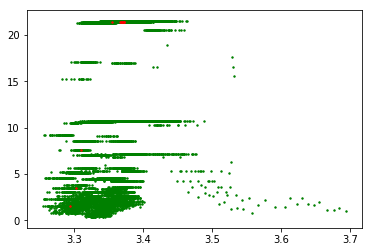

In [341]:
for i in range(0, 342):
    plt.scatter(
        test.loc[:, "v_" + str(i)], test.loc[:, "v_" + str(i) + "_ic_delta"], s=2, c="g"
    )

for i in range(47, 48):
    X_predict = []
    for k in range(test.shape[0]):
        if (test.loc[k, "v_" + str(i)] > 2) & (
            test.loc[k, "v_" + str(i) + "_ic_delta"] < 1000
        ):
            X_predict.append(
                test.loc[k, ["v_" + str(i), "v_" + str(i) + "_ic_delta"]].values.astype(
                    "float"
                )
            )
    if clf.predict(X_predict).tolist().count(-1) > 0:
        predict_list = clf.predict(X_predict).reshape(-1, 1)
        index_list = [k for k, x in enumerate(predict_list) if x == -1]
        print(index_list)
        for j, l in enumerate(index_list):
            plt.scatter(
                test.loc[l, "v_" + str(i)],
                test.loc[l, "v_" + str(i) + "_ic_delta"],
                s=2,
                c="red",
            )
            # plt.show()

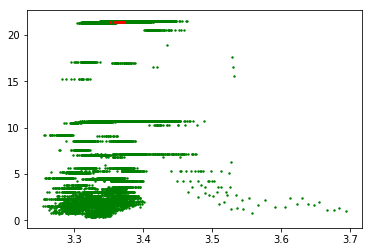

In [308]:
predict_list = clf.predict(X_predict).tolist()
index_list = [k for k, x in enumerate(predict_list) if x == -1]
for i in range(0, 342):
    plt.scatter(
        test.loc[:, "v_" + str(i)], test.loc[:, "v_" + str(i) + "_ic_delta"], s=2, c="g"
    )
for i,k in enumerate(index_list):
    plt.scatter(test.loc[k, "v_23"], test.loc[k, "v_23_ic_delta"], s=2, c="red")

In [330]:
clf.predict(X_predict).reshape(-1, 1)
[k for k, x in enumerate(predict_list) if x == -1]

[1,
 2,
 5,
 92,
 94,
 99,
 100,
 101,
 130,
 132,
 133,
 135,
 137,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161]

[5, 6, 7, 1, 2, 3, 4]